## Setup...

In [1]:
# Various setup, probably mostly unused

from env import TestEnv
import pandas as pd
import json
import os
from conf import LisaLogging
from bart.common.Utils import area_under_curve
from trappy.plotter import plot_trace
from IPython.display import display
from trappy import ILinePlot
from trappy.stats.grammar import Parser
from bart.sched.SchedMultiAssert import SchedMultiAssert
import pandas as pd
from trace import Trace
LisaLogging.setup()
import logging
logging.getLogger('Trace').setLevel(logging.ERROR)
logging.getLogger('Analysis').setLevel(logging.WARNING)
logging.getLogger('EnergyMeter').setLevel(logging.DEBUG)
%matplotlib inline
from platforms.juno_energy import juno_energy
from platforms.pixel_energy import pixel_energy
import tests.eas.generic
from tests.eas.generic import EnergyModelTest
import numpy as np
from IPython.display import display
from wlgen import RTA, Periodic
from executor import Executor
from platforms.hikey_energy import hikey_energy
import numpy as np

2017-02-09 17:20:08,495 INFO    : root         : Using LISA logging configuration:
2017-02-09 17:20:08,497 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


In [2]:
# Some nonsense to get caiman to work on Brendan's computer
p = os.getenv('PATH').split(':')
caiman_path = '/opt/ds5_v5.23.0/bin'
if caiman_path not in p:
    p.insert(0, caiman_path)
    os.environ['PATH'] = ':'.join(p)

In [3]:
te = TestEnv(test_conf={
        'modules': ['cgroups'], 
        'ftrace': {
            'events': ['sched_switch', 'cpu_frequency', 'cpu_idle', 'sched_load_avg_cpu', 'sched_load_avg_task', 'irq*']
        }
    }, force_new=True)

2017-02-09 17:20:08,545 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2017-02-09 17:20:08,546 INFO    : TestEnv      : Loading default (file) target configuration
2017-02-09 17:20:08,547 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2017-02-09 17:20:08,551 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-02-09 17:20:08,551 INFO    : TestEnv      : External tools using:
2017-02-09 17:20:08,552 INFO    : TestEnv      :    ANDROID_HOME: /work/android-sdk-linux
2017-02-09 17:20:08,553 INFO    : TestEnv      :    CATAPULT_HOME: /home/brejac01/sources/lisa/tools/catapult
2017-02-09 17:20:08,554 INFO    : TestEnv      : Devlib modules to load: ['cpuidle', 'cgroups', 'cpufreq']
2017-02-09 17:20:08,554 INFO    : TestEnv      : Connecting Android target [04D314DF000BC57F]
2017-02-09 17:20:08,555 INFO    : TestEnv      : Connection settings:
2017-02-09 17:20:08,556 INFO    : TestEnv      :    {'

In [4]:
# Some nonsense to make LISA treat HiKey with the respect it deserves
from trappy.stats.Topology import Topology
hikey_topology = Topology(clusters=[[0, 1, 2, 3], [4, 5, 6, 7]])
te.topology = hikey_topology
te.platform['clusters'] = {'big': [0, 1, 2, 3], 'little': [4, 5, 6, 7]}

# Define Workloads
We're going to create two workloads with a handful of small tasks, such that they could fit onto a single cluster at the lowest OPP. 

To avoid evertying being thrown out by the periodiciy of the tasks, the start times and periods of the tasks are staggered.

We'll run this same workload both with and without using taskset to force them onto a single cluster.

In [5]:
def get_wloads(nrg_model, cpu=0, type='min', bandwidth_to_eat=0.75, ntasks=16):
    cpu_node = nrg_model.cpu_nodes[cpu]
    cluster_node = cpu_node.parent
    ncpus = len(cluster_node.cpus)
    if type == 'min':
        cpu_cap = cpu_node.min_capacity
    elif type == 'max':
        cpu_cap = cpu_node.max_capacity
        
    total_cap = bandwidth_to_eat * ncpus * cpu_cap
    target_task_cap = total_cap / ntasks
    task_pct = int((target_task_cap / 1024) * 100)
    task_cap = int(1024 * (task_pct / 100.))
    tasks_per_cpu = int(cpu_cap / task_cap)
   
    print "cpu_cap {}".format(cpu_cap)
    print "task_cap {}".format(task_cap)
    print "tasks_per_cpu {}".format(tasks_per_cpu)
    print "total num tasks {}".format(ntasks)
    
    # Stagger the workloads so that they prevent shared idle states
    period_s = 10e-3
    stagger_s = 0.7e-3
    delays = np.arange(period_s, step=stagger_s)
    
    if len(delays) > ntasks:
        print "WARNING: not enough tasks to cover period with wakeups"
    
    tasks = {}
    for i in range(ntasks):
        tasks['{}pct_{}'.format(task_pct, i)] = {
            'kind': 'Periodic',
            'params': {
                'duty_cycle_pct': task_pct,
                'period_ms' : period_s * 1e3 + (i - (ntasks / 2)),
                'delay_s' : delays[i % len(delays)],
                'duration_s': 2
            }
        }
    
    wloads = {
        'forced_pack': {
            'type': 'rt-app',
            'conf': {
                'class': 'profile',
                'params': tasks,
                'cpus': [0, 1, 2, 3]
            }
        },
        'break_packing': {
            'type': 'rt-app',
            'conf': {
                'class': 'profile',
                'params': tasks,
                'cpus': [2, 3, 4, 5],
            }
        }
    }
        
    return wloads

In [6]:
wloads = get_wloads(hikey_energy, type='max')

cpu_cap 1024
task_cap 184
tasks_per_cpu 5
total num tasks 16


# Run workloads
Now we'll run the workloads with the powersave governor

In [7]:
poor_mans_powersave = { # No powersave governor in hikey_defconfig
    'governor': 'userspace',
    'freqs':{
        0: 208000,
    }
}
performance = {
    'governor': 'performance'
}
executor = Executor(te, {
        'confs': [{
                'tag': 'myconf',
                'flags': ['ftrace', 'freeze_userspace'],
                'cpufreq': performance,
            }],
        'wloads': wloads,
        'iterations': 10
    })

2017-02-09 17:20:17,811 INFO    : Executor     : Loading custom (inline) test configuration
2017-02-09 17:20:17,812 INFO    : Executor     : 
2017-02-09 17:20:17,813 INFO    : Executor     : ################################################################################
2017-02-09 17:20:17,814 INFO    : Executor     : Experiments configuration
2017-02-09 17:20:17,815 INFO    : Executor     : ################################################################################
2017-02-09 17:20:17,816 INFO    : Executor     : Configured to run:
2017-02-09 17:20:17,817 INFO    : Executor     :      1 target configurations:
2017-02-09 17:20:17,818 INFO    : Executor     :       myconf
2017-02-09 17:20:17,819 INFO    : Executor     :      2 workloads (10 iterations each)
2017-02-09 17:20:17,820 INFO    : Executor     :       break_packing, forced_pack
2017-02-09 17:20:17,821 INFO    : Executor     : Total: 20 experiments
2017-02-09 17:20:17,822 INFO    : Executor     : Results will be collected

In [8]:
executor.run()

2017-02-09 17:20:18,631 INFO    : Executor     : 
2017-02-09 17:20:18,633 INFO    : Executor     : ################################################################################
2017-02-09 17:20:18,634 INFO    : Executor     : Experiments execution
2017-02-09 17:20:18,635 INFO    : Executor     : ################################################################################
2017-02-09 17:20:18,637 INFO    : Executor     : 
2017-02-09 17:20:18,638 INFO    : Executor     : ================================================================================
2017-02-09 17:20:18,639 INFO    : Executor     : configuring target for [myconf] experiments
2017-02-09 17:20:18,959 WARNING : Executor     : Setting target SELinux in permissive mode
2017-02-09 17:20:19,135 INFO    : Executor     : Configuring all CPUs to use [performance] cpufreq governor
2017-02-09 17:20:19,302 INFO    : Workload     : Setup new workload break_packing
2017-02-09 17:20:19,304 INFO    : Workload     : Workload duratio

2017-02-09 17:20:29,427 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:20:29,437 INFO    : Workload     : Workload execution START:
2017-02-09 17:20:29,439 INFO    : Workload     :    /data/local/tmp/bin/taskset 0x3C /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/break_packing_00.json 2>&1
2017-02-09 17:20:31,887 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.437319
2017-02-09 17:20:37,583 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:20:37,585 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/1/trace.dat
2017-02-09 17:20:37,586 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:20:37,588 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/1/trace_stat.json
2017-02-09 17:20:37,589 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:20:38,326 INFO    : Executor     : Calling postrun step
2017-02-09 17:20:40,699 INFO    : Executor     : ----------------------------------

2017-02-09 17:20:50,344 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:20:50,354 INFO    : Workload     : Workload execution START:
2017-02-09 17:20:50,356 INFO    : Workload     :    /data/local/tmp/bin/taskset 0x3C /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/break_packing_00.json 2>&1
2017-02-09 17:20:52,850 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.437914
2017-02-09 17:20:58,334 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:20:58,336 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/2/trace.dat
2017-02-09 17:20:58,337 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:20:58,338 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/2/trace_stat.json
2017-02-09 17:20:58,339 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:20:59,088 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:20:59,090

2017-02-09 17:21:08,732 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:21:08,742 INFO    : Workload     : Workload execution START:
2017-02-09 17:21:08,744 INFO    : Workload     :    /data/local/tmp/bin/taskset 0x3C /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/break_packing_00.json 2>&1
2017-02-09 17:21:11,220 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.442003
2017-02-09 17:21:16,681 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:21:16,683 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/3/trace.dat
2017-02-09 17:21:16,684 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:21:16,685 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/3/trace_stat.json
2017-02-09 17:21:16,686 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:21:17,425 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:21:17,428

2017-02-09 17:21:26,928 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:21:26,937 INFO    : Workload     : Workload execution START:
2017-02-09 17:21:26,939 INFO    : Workload     :    /data/local/tmp/bin/taskset 0x3C /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/break_packing_00.json 2>&1
2017-02-09 17:21:29,417 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.445275
2017-02-09 17:21:35,089 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:21:35,091 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/4/trace.dat
2017-02-09 17:21:35,092 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:21:35,093 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/4/trace_stat.json
2017-02-09 17:21:35,094 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:21:35,844 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:21:35,846

2017-02-09 17:21:45,646 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:21:45,656 INFO    : Workload     : Workload execution START:
2017-02-09 17:21:45,658 INFO    : Workload     :    /data/local/tmp/bin/taskset 0x3C /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/break_packing_00.json 2>&1
2017-02-09 17:21:48,146 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.444998
2017-02-09 17:21:53,777 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:21:53,779 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/5/trace.dat
2017-02-09 17:21:53,781 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:21:53,782 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/5/trace_stat.json
2017-02-09 17:21:53,783 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:21:54,525 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:21:54,528

2017-02-09 17:22:04,199 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:22:04,208 INFO    : Workload     : Workload execution START:
2017-02-09 17:22:04,210 INFO    : Workload     :    /data/local/tmp/bin/taskset 0x3C /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/break_packing_00.json 2>&1
2017-02-09 17:22:06,702 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.447266
2017-02-09 17:22:12,193 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:22:12,195 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/6/trace.dat
2017-02-09 17:22:12,196 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:22:12,197 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/6/trace_stat.json
2017-02-09 17:22:12,198 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:22:12,930 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:22:12,932

2017-02-09 17:22:22,590 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:22:22,602 INFO    : Workload     : Workload execution START:
2017-02-09 17:22:22,604 INFO    : Workload     :    /data/local/tmp/bin/taskset 0x3C /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/break_packing_00.json 2>&1
2017-02-09 17:22:25,099 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.448491
2017-02-09 17:22:30,653 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:22:30,655 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/7/trace.dat
2017-02-09 17:22:30,656 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:22:30,657 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/7/trace_stat.json
2017-02-09 17:22:30,658 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:22:31,401 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:22:31,403

2017-02-09 17:22:41,111 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:22:41,119 INFO    : Workload     : Workload execution START:
2017-02-09 17:22:41,121 INFO    : Workload     :    /data/local/tmp/bin/taskset 0x3C /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/break_packing_00.json 2>&1
2017-02-09 17:22:43,609 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.449969
2017-02-09 17:22:49,147 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:22:49,149 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/8/trace.dat
2017-02-09 17:22:49,150 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:22:49,152 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/8/trace_stat.json
2017-02-09 17:22:49,153 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:22:49,895 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:22:49,898

2017-02-09 17:22:59,777 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:22:59,786 INFO    : Workload     : Workload execution START:
2017-02-09 17:22:59,788 INFO    : Workload     :    /data/local/tmp/bin/taskset 0x3C /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/break_packing_00.json 2>&1
2017-02-09 17:23:02,285 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.449819
2017-02-09 17:23:07,857 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:23:07,859 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/9/trace.dat
2017-02-09 17:23:07,861 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:23:07,862 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/9/trace_stat.json
2017-02-09 17:23:07,863 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:23:08,614 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:23:08,616

2017-02-09 17:23:18,215 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:23:18,226 INFO    : Workload     : Workload execution START:
2017-02-09 17:23:18,229 INFO    : Workload     :    /data/local/tmp/bin/taskset 0x3C /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/break_packing_00.json 2>&1
2017-02-09 17:23:20,706 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.451450
2017-02-09 17:23:26,466 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:23:26,468 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/10/trace.dat
2017-02-09 17:23:26,469 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:23:26,470 INFO    : Executor     :    <res_dir>/rtapp:myconf:break_packing/10/trace_stat.json
2017-02-09 17:23:26,471 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:23:27,191 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:23:27,1

2017-02-09 17:23:37,395 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:23:37,403 INFO    : Workload     : Workload execution START:
2017-02-09 17:23:37,405 INFO    : Workload     :    /data/local/tmp/bin/taskset 0xF /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/forced_pack_00.json 2>&1
2017-02-09 17:23:39,887 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.437427
2017-02-09 17:23:45,636 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:23:45,638 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/1/trace.dat
2017-02-09 17:23:45,640 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:23:45,641 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/1/trace_stat.json
2017-02-09 17:23:45,642 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:23:46,367 INFO    : Executor     : Calling postrun step
2017-02-09 17:23:48,818 INFO    : Executor     : -----------------------------------------

2017-02-09 17:23:58,376 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:23:58,385 INFO    : Workload     : Workload execution START:
2017-02-09 17:23:58,387 INFO    : Workload     :    /data/local/tmp/bin/taskset 0xF /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/forced_pack_00.json 2>&1
2017-02-09 17:24:00,866 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.440060
2017-02-09 17:24:06,380 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:24:06,382 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/2/trace.dat
2017-02-09 17:24:06,383 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:24:06,384 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/2/trace_stat.json
2017-02-09 17:24:06,385 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:24:07,104 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:24:07,106 INFO  

2017-02-09 17:24:16,685 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:24:16,697 INFO    : Workload     : Workload execution START:
2017-02-09 17:24:16,699 INFO    : Workload     :    /data/local/tmp/bin/taskset 0xF /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/forced_pack_00.json 2>&1
2017-02-09 17:24:19,184 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.453469
2017-02-09 17:24:24,897 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:24:24,900 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/3/trace.dat
2017-02-09 17:24:24,901 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:24:24,902 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/3/trace_stat.json
2017-02-09 17:24:24,904 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:24:25,643 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:24:25,645 INFO  

2017-02-09 17:24:35,480 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:24:35,489 INFO    : Workload     : Workload execution START:
2017-02-09 17:24:35,491 INFO    : Workload     :    /data/local/tmp/bin/taskset 0xF /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/forced_pack_00.json 2>&1
2017-02-09 17:24:38,041 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.438725
2017-02-09 17:24:43,798 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:24:43,800 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/4/trace.dat
2017-02-09 17:24:43,801 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:24:43,802 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/4/trace_stat.json
2017-02-09 17:24:43,803 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:24:44,565 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:24:44,567 INFO  

2017-02-09 17:24:54,311 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:24:54,321 INFO    : Workload     : Workload execution START:
2017-02-09 17:24:54,323 INFO    : Workload     :    /data/local/tmp/bin/taskset 0xF /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/forced_pack_00.json 2>&1
2017-02-09 17:24:56,787 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.452841
2017-02-09 17:25:02,270 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:25:02,272 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/5/trace.dat
2017-02-09 17:25:02,273 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:25:02,275 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/5/trace_stat.json
2017-02-09 17:25:02,276 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:25:03,012 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:25:03,015 INFO  

2017-02-09 17:25:12,608 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:25:12,617 INFO    : Workload     : Workload execution START:
2017-02-09 17:25:12,619 INFO    : Workload     :    /data/local/tmp/bin/taskset 0xF /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/forced_pack_00.json 2>&1
2017-02-09 17:25:15,109 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.452699
2017-02-09 17:25:20,672 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:25:20,674 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/6/trace.dat
2017-02-09 17:25:20,675 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:25:20,676 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/6/trace_stat.json
2017-02-09 17:25:20,677 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:25:21,402 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:25:21,404 INFO  

2017-02-09 17:25:31,146 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:25:31,156 INFO    : Workload     : Workload execution START:
2017-02-09 17:25:31,158 INFO    : Workload     :    /data/local/tmp/bin/taskset 0xF /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/forced_pack_00.json 2>&1
2017-02-09 17:25:33,645 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.447749
2017-02-09 17:25:39,206 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:25:39,208 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/7/trace.dat
2017-02-09 17:25:39,209 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:25:39,210 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/7/trace_stat.json
2017-02-09 17:25:39,211 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:25:39,974 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:25:39,976 INFO  

2017-02-09 17:25:49,965 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:25:49,975 INFO    : Workload     : Workload execution START:
2017-02-09 17:25:49,977 INFO    : Workload     :    /data/local/tmp/bin/taskset 0xF /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/forced_pack_00.json 2>&1
2017-02-09 17:25:52,463 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.454081
2017-02-09 17:25:57,945 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:25:57,946 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/8/trace.dat
2017-02-09 17:25:57,948 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:25:57,949 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/8/trace_stat.json
2017-02-09 17:25:57,950 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:25:58,679 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:25:58,681 INFO  

2017-02-09 17:26:08,513 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:26:08,523 INFO    : Workload     : Workload execution START:
2017-02-09 17:26:08,525 INFO    : Workload     :    /data/local/tmp/bin/taskset 0xF /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/forced_pack_00.json 2>&1
2017-02-09 17:26:11,013 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.440430
2017-02-09 17:26:16,643 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:26:16,645 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/9/trace.dat
2017-02-09 17:26:16,646 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:26:16,647 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/9/trace_stat.json
2017-02-09 17:26:16,649 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:26:17,386 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:26:17,388 INFO  

2017-02-09 17:26:27,050 DEBUG   : EnergyMeter  : RESET: []
2017-02-09 17:26:27,060 INFO    : Workload     : Workload execution START:
2017-02-09 17:26:27,061 INFO    : Workload     :    /data/local/tmp/bin/taskset 0xF /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/run_dir/forced_pack_00.json 2>&1
2017-02-09 17:26:29,554 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.454300
2017-02-09 17:26:35,225 INFO    : Executor     : Collected FTrace binary trace:
2017-02-09 17:26:35,227 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/10/trace.dat
2017-02-09 17:26:35,228 INFO    : Executor     : Collected FTrace function profiling:
2017-02-09 17:26:35,229 INFO    : Executor     :    <res_dir>/rtapp:myconf:forced_pack/10/trace_stat.json
2017-02-09 17:26:35,231 INFO    : Executor     : Un-freezing userspace tasks
2017-02-09 17:26:35,992 INFO    : Executor     : --------------------------------------------------------------------------------
2017-02-09 17:26:35,994 INFO

# Examine Results

In [9]:
traces = [Trace(te.platform, e.out_dir, ['sched_switch', 'cpu_idle', 'cpu_frequency']) for e in executor.experiments]

## Plot task residency
It's worth visually inspecting the task residency to check that the "un-packed" runs were really unpacked and that there aren't any aliasing problems that would obviously make un-packed runs just as efficient as packed runs

In [10]:
if True:
    for trace in traces:
        plot_trace(trace.ftrace)

In [11]:
traces[0].analysis.frequency.plotClusterFrequencies()

2017-02-09 17:27:19,220 WARNING : Analysis     : Events [cpu_frequency] not found, plot DISABLED!


In [12]:
# Plot cluster active-time. This shouldn't be needed, I used this to figure out when the 
# workload was really stressing both clusters where it wasn't packed (i.e. whether idle periods were aligned)
if False:
    clusters = [[0, 1, 2, 3], [4, 5, 6, 7]]
    for trace in traces:
        ca_signals = []
        for cluster in clusters:
            ca_signals.append(pd.DataFrame(trace.getClusterActiveSignal(cluster)))
        ILinePlot(ca_signals, column=0, drawstyle='steps-post', fill=True, fill_alpha=0.8).view() 
        trace.analysis.idle.plotClusterIdleStateResidency()

In [13]:
def get_energy(experiment):
    with open(os.path.join(experiment.out_dir, 'energy.json')) as f:
        return json.load(f)['BAT']

In [14]:
def get_packing_ratio(experiment, trace=None):
    if not trace:
        trace = Trace(te.platform, experiment.out_dir, ['sched_switch'])
    ma = SchedMultiAssert(trace.ftrace, te.topology, experiment.wload.tasks.keys())
    clusters_time = []
    for cluster in te.topology.get_level('cluster'):
        residencies = [t['residency'] for p, t in ma.getResidency('cluster', cluster).iteritems()]
        clusters_time.append(sum(residencies))
    total_time = sum(clusters_time)
    cluster_props = [c / total_time for c in clusters_time]
    return max(cluster_props) - min(cluster_props)

In [15]:
results = []
for experiment, trace in zip(executor.experiments, traces):
    results.append({
            'pack_ratio': get_packing_ratio(experiment, trace),
            'energy': get_energy(experiment)
    })
df = pd.DataFrame(results, columns=['pack_ratio', 'energy'])
df.corr()

pack_ratio   energy
pack_ratio     1.00000  0.12539
energy         0.12539  1.00000

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


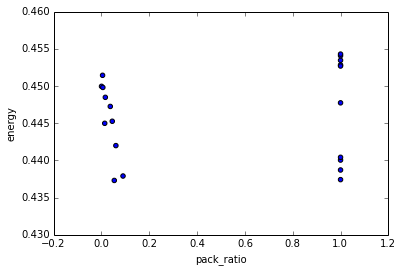

In [16]:
df.plot(kind='scatter', x='pack_ratio', y='energy')

# Compare energy usage between packed an unpacked runs

Split up workload runs between those that were packed onto a single cluster and those that weren't. Then compare the mean energy usage for those two classes of workload runs.

In [17]:
def examine_experiment(experiment):
    trace = Trace(te.platform, experiment.out_dir, ['sched_switch'])
    ma = SchedMultiAssert(trace.ftrace, hikey_topology, experiment.wload.tasks.keys())
    cluster_conclusions = []
    for cluster in te.topology.get_level('cluster'):
        residencies = [t['residency'] for p, t in ma.getResidency('cluster', cluster, percent=True).iteritems()]
        if all(r > 90 for r in residencies):
            cluster_conclusions.append('PACKED')
        else:
            cluster_conclusions.append(None)
    packed = [i for i, c in enumerate(cluster_conclusions) if c == 'PACKED']
    with open(os.path.join(experiment.out_dir, 'energy.json')) as f:
        energy = json.load(f)
        energy = energy['BAT']
    if not packed:
        print "I don't think we packed onto any cluster"
        return False, energy
        # plot_trace(trace.ftrace)
    elif len(packed) == 1:
        [i] = packed
        print 'I think we packed onto cluster {} ({})'.format(i, te.topology.get_node('cluster', i))
        return True, energy
    else:
        raise Exception('i am borken')

In [18]:
previous_energy_records = [[], []] # Use this to store old results

In [19]:
energy_records = previous_energy_records
for experiment in executor.experiments:
    packed, energy = examine_experiment(experiment)
    energy_records[packed].append(energy)

I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I don't think we packed onto any cluster
I think we packed onto cluster 0 ([0, 1, 2, 3])
I think we packed onto cluster 0 ([0, 1, 2, 3])
I think we packed onto cluster 0 ([0, 1, 2, 3])
I think we packed onto cluster 0 ([0, 1, 2, 3])
I think we packed onto cluster 0 ([0, 1, 2, 3])
I think we packed onto cluster 0 ([0, 1, 2, 3])
I think we packed onto cluster 0 ([0, 1, 2, 3])
I think we packed onto cluster 0 ([0, 1, 2, 3])
I think we packed onto cluster 0 ([0, 1, 2, 3])
I think we packed onto cluster 0 ([0, 1, 2, 3])


In [20]:
unpacked_nrg, packed_nrg = [np.mean(n) for n in energy_records]
print 'Average energy when not packed: {}'.format(unpacked_nrg)
print 'Average energy when packed: {}'.format(packed_nrg)

print 'Improvement by packing: {:02f}%'.format(((unpacked_nrg - packed_nrg) / unpacked_nrg) * 100)

Average energy when not packed: 0.445450365876
Average energy when packed: 0.447178165709
Improvement by packing: -0.387877%
